In [29]:
library(dplyr)
library(fuzzyjoin)
library(readxl)
library(IRanges)

#install.packages("stringr")
library(stringr)
library(tidyr)
library(tibble)

In [3]:
#samples <- snakemake@params[["samples"]]
#all_types <- snakemake@params[["all_types"]]


samples <- c('Row-01', 'Row-02', 'Row-03', 'Row-04',
             'Col-01', 'Col-02', 'Col-03', 'Col-04')

all_types <- c("Mu1_L", "Mu1_R",
"Mu2_L",
"Mu2_R",
"Mu3_L",
"Mu3_R",
"Mu4_L",
"Mu4_R",
"Mu5_L",
"Mu5_R",
"Mu7_L",
"Mu7_R",
"Mu8_L",
"Mu8_R",
"MuDR_L",
"MuDR_R",
"Mu10_L",
"Mu10_R",
"Mu11_L",
"Mu11_R",
"Mu12_L",
"Mu12_R",
"Mu13_L",
"Mu13_R",
"Mu14_L",
"Mu14_R",
"Mu15_L",
"Mu15_R",
"Mu16_L",
"Mu16_R",
"Mu17_L",
"Mu17_R",
"Mu18_L",
"Mu18_R",
"Mu19_L",
"Mu19_R")



all_insertions <- read.csv("results/insertions_table_final/all_identified_insertions.csv", header = TRUE)

In [4]:
base_all_types <- str_remove(all_types, c("_L"))
base_all_types <- str_remove(base_all_types, c("_R"))
base_all_types <- unique(base_all_types)
base_all_types

[1] "Mu1"  "Mu2"  "Mu3"  "Mu4"  "Mu5"  "Mu7"  "Mu8"  "MuDR" "Mu10" "Mu11"
[11] "Mu12" "Mu13" "Mu14" "Mu15" "Mu16" "Mu17" "Mu18" "Mu19"

In [5]:
#create insertions table with additional columns per (Mu) element/type
all_insertions_typed <- all_insertions

all_insertions_typed[,all_types]=0
#add additional column for uncategorized reads
all_insertions_typed[,"uncategorized"]=0

head(all_insertions_typed)

#for (t in all_types) {
#  all_insertions_typed %>%
#  tibble::add_column(get(t) = 0) %>%
#  head() %>% print()
#}

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3124440,3124448,Col-01,2,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1,3772030,3772038,Col-01,2,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1,4498708,4498716,Col-01,8,5,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1,4736284,4736292,Col-01,4,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1,4909718,4909726,Col-01,9,8,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1,8308462,8308470,Col-01,12,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [79]:
#read-in final sample files
for (s in samples) {
  tmp_type_file <- read.csv(paste0("results/te_typing/", s, "/", s, "_te_types_merged.tsv"), header = TRUE, sep="\t")
  tmp_type_file$Strand <- as.character(tmp_type_file$Strand)
  assign(paste0(s, "_type_file"), tmp_type_file)
}

head(`Col-02_type_file`)

,Name,Strand,Type
,<chr>,<chr>,<chr>
1,E00591:404:HFCMWCCX2:7:1101:10480:1573,1,Mu11_L
2,E00591:404:HFCMWCCX2:7:1101:16092:1625,1,Mu11_L
3,E00591:404:HFCMWCCX2:7:1101:13646:1678,1,Mu11_L
4,E00591:404:HFCMWCCX2:7:1101:14681:1678,1,Mu11_L
5,E00591:404:HFCMWCCX2:7:1101:13332:1766,1,Mu11_L
6,E00591:404:HFCMWCCX2:7:1101:18182:1766,1,Mu11_L


In [80]:
#modified, but core idea idea from here - https://stackoverflow.com/a/12088263
number2binary = function(number, noBits) {
       binary_vector = rev(as.numeric(intToBits(number)))
       if(missing(noBits)) {
          return(rev(binary_vector))
       } else {
          return(rev(binary_vector[-(1:(length(binary_vector) - noBits))]))
       }
}

#num=163
#number2binary(num, 8)[7]
#number2binary(num, 8)[8]

In [81]:
#need to load all sam files
for (s in samples) {
    SAM_path <- paste0("results/dedup_sam/", s, ".dedup.sam")
    SAM_object <- paste0("sam_", s)
    assign(SAM_object, read.csv(SAM_path, sep = "\t", header = FALSE, row.names = NULL))
    #take only the forst for columns and the sequence
    assign(SAM_object, get(SAM_object)[,c(1:4,10)])
    assign(SAM_object,
           get(SAM_object) %>%
             #some renaming of the header
             dplyr::rename(Name=V1, Flag=V2, Chr=V3, Start=V4) %>%
             #compute lengths of the alignments
             mutate(Length = str_length(V10)) %>%
             #compute and add End coordinate of reads
             mutate(End = Start+Length-1) %>%
             #drop Lengh & V10 (Sequence) columns
             select(-V10, -Length) %>%
             #translate Flag into forward (+) or reverse (-) strand mapping/read
             rowwise() %>%
             mutate(
               Strand = case_when(
                 number2binary(Flag, 8)[7] == 1 & number2binary(Flag, 8)[8] == 0 ~ "1",
                 number2binary(Flag, 8)[7] == 0 & number2binary(Flag, 8)[8] == 1 ~ "2",
                 TRUE ~ "LOST"
               )
             ) %>%
            select(-Flag) %>%
            relocate(Strand, .after=Name)
    )
}

In [82]:
head(`sam_Col-01`)
head(`sam_Row-02`)

Name,Strand,Chr,Start,End
<chr>,<chr>,<chr>,<int>,<dbl>
E00591:404:HFCMWCCX2:7:1101:19197:55666,1,1,44317,44343
E00591:404:HFCMWCCX2:7:1101:19197:55666,2,1,44317,44343
E00591:404:HFCMWCCX2:7:1101:15138:9572,2,1,262584,262627
E00591:404:HFCMWCCX2:7:1101:15138:9572,1,1,262584,262627
E00591:404:HFCMWCCX2:7:1101:7811:72614,1,1,971328,971418
E00591:404:HFCMWCCX2:7:1101:7811:72614,2,1,971342,971418


Name,Strand,Chr,Start,End
<chr>,<chr>,<chr>,<int>,<dbl>
E00591:404:HFCMWCCX2:7:1101:24759:36258,1,1,56107,56207
E00591:404:HFCMWCCX2:7:1101:24759:36258,2,1,56112,56207
E00591:404:HFCMWCCX2:7:1102:27945:33691,1,1,56215,56265
E00591:404:HFCMWCCX2:7:1102:27945:33691,2,1,56215,56265
E00591:404:HFCMWCCX2:7:1101:7364:5423,2,1,215243,215271
E00591:404:HFCMWCCX2:7:1101:25570:72930,2,1,215243,215282


### Annotating with type information

In [83]:
for (row in 1:nrow(all_insertions_typed)) {
  
  #take row to work on
  tmp_ins <- all_insertions_typed[row,]

  #match Sample with sam object
  tmp_sam <- get(paste0("sam_", tmp_ins$Sample))

  #match sample of insertion file with te typing file
  tmp_type_file <- get(paste0(tmp_ins$Sample, "_type_file"))


  # fuzzyjoin for overlap + end or start needs to match
  tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(tmp_ins,
                             tmp_sam, 
                              by=c("Chr", "Start", "End")
                            ) %>%
                       select(Name, Strand, Chr.y, Start.y, End.y) %>%
                       dplyr::rename(Chr=Chr.y, Start=Start.y, End=End.y) %>%
                       filter(Start == tmp_ins$Start | 
                              Start == tmp_ins$End | 
                              End == tmp_ins$Start | 
                              End == tmp_ins$End)

  #associate sam reads with type information
  tmp_merge_ins_sam_typed_summary <- dplyr::left_join(tmp_merge_ins_sam, tmp_type_file, by = c("Name"="Name", "Strand"="Strand"), na_matches = "na") %>%
  group_by(Type) %>%
  summarize(n = n()) %>%
  #change NA to uncategorized
  tidyr::replace_na(list(Type = "uncategorized"))

  #add number of type association to current row
  for (t in tmp_merge_ins_sam_typed_summary$Type) {
    tmp_ins <- tmp_ins %>%
    mutate({{t}} := tmp_merge_ins_sam_typed_summary %>%
                 filter(Type == {{t}}) %>%
                 pull(n)
          )
  }
    
  #switch out new for old row in table
  all_insertions_typed[row,] <- tmp_ins
}




Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "7", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "8", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "1", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "3", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "10", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "1", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, row, , value = structure(list(Chr = "3", :
“provided 44 variables to replace 43 variables”
Warning message in `[<-.data.frame`(`*tmp*`, ro

In [85]:
head(all_insertions_typed)
nrow(all_insertions_typed)

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3124440,3124448,Col-01,2,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4
2,1,3772030,3772038,Col-01,2,2,2,2,0,2,⋯,0,0,0,2,2,0,0,0,0,0
3,1,4498708,4498716,Col-01,8,5,0,2,0,0,⋯,0,2,0,2,2,0,0,2,0,6
4,1,4736284,4736292,Col-01,4,2,0,0,0,0,⋯,0,1,0,0,0,0,0,1,0,3
5,1,4909718,4909726,Col-01,9,8,0,2,0,0,⋯,0,0,0,2,2,0,0,0,0,11
6,1,8308462,8308470,Col-01,12,2,1,2,0,1,⋯,0,0,0,2,2,0,0,0,0,9


[1] 4680

In [11]:
#all_insertions_typed %>%
#  filter(MuDR_L != 0) %>%
#  select(MuDR_L, MuDR_R, Mu8_L, Mu8_R)

#all_insertions_typed %>%
#  filter(Mu5_R != 0) %>%
#  select(Mu5_R, Mu7_L, Mu7_R)

### dev notes and tests

In [118]:
tmp_ins <- all_insertions_typed[3,]
#tmp_ins

#tmp_ins$Sample
#tmp_ins$Start
#tmp_ins$End


#match Sample with sam object
tmp_sam <- get(paste0("sam_", tmp_ins$Sample))

#match sample of insertion file with te typing file
tmp_type_file <- get(paste0(tmp_ins$Sample, "_type_file"))


# fuzzyjoin for overlap + end or start needs to match
tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(tmp_ins,
                             tmp_sam, 
                              by=c("Chr", "Start", "End")
                            ) %>%
select(Name, Strand, Chr.y, Start.y, End.y) %>%
#names()
dplyr::rename(Chr=Chr.y, Start=Start.y, End=End.y) %>%
filter(Start == tmp_ins$Start | 
       Start == tmp_ins$End | 
       End == tmp_ins$Start | 
       End == tmp_ins$End)


head(tmp_merge_ins_sam)

,Name,Strand,Chr,Start,End
,<chr>,<chr>,<chr>,<int>,<dbl>
1,E00591:404:HFCMWCCX2:7:1102:21947:14441,2,1,4498621,4498716
2,E00591:404:HFCMWCCX2:7:1101:2757:39036,1,1,4498662,4498716
3,E00591:404:HFCMWCCX2:7:1101:2757:39036,2,1,4498662,4498716
4,E00591:404:HFCMWCCX2:7:1101:20232:17061,1,1,4498667,4498716
5,E00591:404:HFCMWCCX2:7:1101:20232:17061,2,1,4498667,4498716
6,E00591:404:HFCMWCCX2:7:1101:23937:60255,2,1,4498708,4498766


In [119]:
head(all_insertions_typed)

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3124440,3124448,Col-01,2,2,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4
2,1,3772030,3772038,Col-01,2,2,2,2,0,2,⋯,0,0,0,2,2,0,0,0,0,0
3,1,4498708,4498716,Col-01,8,5,0,2,0,0,⋯,0,2,0,2,2,0,0,2,0,6
4,1,4736284,4736292,Col-01,4,2,0,0,0,0,⋯,0,1,0,0,0,0,0,1,0,3
5,1,4909718,4909726,Col-01,9,8,0,2,0,0,⋯,0,0,0,2,2,0,0,0,0,11
6,1,8308462,8308470,Col-01,12,2,1,2,0,1,⋯,0,0,0,2,2,0,0,0,0,9


In [87]:
tmp_merge_ins_sam_typed_summary <- dplyr::left_join(tmp_merge_ins_sam, tmp_type_file, by = c("Name"="Name", "Strand"="Strand"), na_matches = "na") %>%
  group_by(Type) %>%
  summarize(n = n()) %>%
  #change NA to uncategorized
  tidyr::replace_na(list(Type = "uncategorized"))

for (t in tmp_merge_ins_sam_typed_summary$Type) {
  tmp_ins <- tmp_ins %>%
  mutate({{t}} := tmp_merge_ins_sam_typed_summary %>%
                 filter(Type == {{t}}) %>%
                 pull(n)
         )
}

In [88]:
head(tmp_merge_ins_sam_typed_summary)

tmp_merge_ins_sam_typed_summary$Type

Type,n
<chr>,<int>
Mu1_R,2
Mu11_L,2
Mu14_L,2
Mu16_L,2
Mu17_L,2
Mu17_R,2


[1] "Mu1_R"         "Mu11_L"        "Mu14_L"        "Mu16_L"       
 [5] "Mu17_L"        "Mu17_R"        "Mu19_L"        "Mu5_R"        
 [9] "Mu7_L"         "Mu7_R"         "Mu8_R"         "MuDR_L"       
[13] "MuDR_R"        "uncategorized"

In [16]:
head(tmp_ins)

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
3,1,4498708,4498716,Col-01,8,5,0,2,0,0,⋯,0,2,0,2,2,0,0,2,0,6


In [89]:
for (t in tmp_merge_ins_sam_typed_summary$Type) {
  print(t)
}

[1] "Mu1_R"
[1] "Mu11_L"
[1] "Mu14_L"
[1] "Mu16_L"
[1] "Mu17_L"
[1] "Mu17_R"
[1] "Mu19_L"
[1] "Mu5_R"
[1] "Mu7_L"
[1] "Mu7_R"
[1] "Mu8_R"
[1] "MuDR_L"
[1] "MuDR_R"
[1] "uncategorized"


In [90]:
for (t in tmp_merge_ins_sam_typed_summary$Type) {
  tmp_ins <- tmp_ins %>%
  mutate({{t}} := tmp_merge_ins_sam_typed_summary %>%
                 filter(Type == {{t}}) %>%
                 pull(n)
         )
}

head(tmp_ins)

#tmp_ins %>%
#  mutate(Mu1_R = tmp_merge_ins_sam_typed_summary %>%
#                 filter(Type == "Mu1_R") %>%
#                 pull(n)
#         )

,Chr,Start,End,Sample,StartReads,EndReads,Mu1_L,Mu1_R,Mu2_L,Mu2_R,⋯,Mu15_R,Mu16_L,Mu16_R,Mu17_L,Mu17_R,Mu18_L,Mu18_R,Mu19_L,Mu19_R,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
3,1,4498708,4498716,Col-01,8,5,0,2,0,0,⋯,0,2,0,2,2,0,0,2,0,6


In [19]:
tmp_merge_ins_sam_typed_summary %>%
  filter(Type == "Mu1_R") %>%
  pull(n)

[1] 2

In [20]:
head(ttt)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'ttt' not found


In [91]:
ttt <- all_insertions_typed#[1:100,]
#head(ttt)


for (t in base_all_types) {
    
  tmp_left <- paste0(t, "_L")
  tmp_right <- paste0(t, "_R")
    
  ttt <- ttt %>%
#    rowwise() %>%
    #add total amount of reads supporting insertion
    mutate(TotalReads = StartReads + EndReads) %>%
    dplyr::relocate(TotalReads, .after = EndReads) %>%
    #add total amount of support reads per (Mu) type
    mutate("{t}_total" := .data[[tmp_left]] + .data[[tmp_right]]) #%>%
#    rowwise() %>%
#    select(., matches("_total")) #%>%
#    mutate(Class = names(c(StartReads, EndReads))[max.col(.)])
}

ttt <- ttt %>%
 relocate(uncategorized, .after = last_col())

head(ttt)

#create df to write to
sss <- ttt# %>%
#  tibble::add_column(all_max_value = 0, all_n_max_value = 0, type_max_value = 0, type_n_max_value = 0)
#  select(., matches(c("_total", "uncategorized")))
#sss[,c("all_max_value","all_n_max_value", "type_max_value","type_n_max_value")]=0



sss <- sss %>%
  rowwise() %>%
  #max value for all total and uncategorized columns
  mutate(all_max_value = max(across(ends_with(c("_total", "uncategorized"))))) %>%
  #also compute max value for all types excl. uncategorized
  mutate(type_max_value = max(across(ends_with("_total")))) %>%
  #number of max values for all total and uncategorized columns
  #also, catch edge case when no type has any associated values/reads
  mutate(all_n_max_value = case_when(
           all_max_value > 0 ~ length(which(across(ends_with(c("_total", "uncategorized", "all_max_value")))==all_max_value)),
           TRUE ~ as.integer(0)
    )
  ) %>%
  #number of max values for all total columns excl. uncategorized
  #again, catch edge case when no type has any associated values/reads
  mutate(type_n_max_value = case_when(
            type_max_value > 0 ~ length(which(across(ends_with(c("_total", "type_max_value")))==type_max_value)),
            TRUE ~ as.integer(0)
         )
  )

head(sss)

sss[1,] %>%
  select(., ends_with("_total"))

#loop over df to identify uncear cases in which the max support for type classification is tied
#create column with info on whether or not one type is more often than others
sss <- sss %>%
  mutate(all_TIES = 
    case_when(
      all_n_max_value > 2 ~ "TIED",
      all_n_max_value == 2 ~ "WINNER",
      TRUE ~ "NO READS"
    ) 
  ) %>%
  mutate(type_TIES = 
    case_when(
      type_n_max_value > 2 ~ "TIED",
      type_n_max_value == 2 ~ "WINNER",
      TRUE ~ "NO READS"
    ) 
  )

head(sss)


#isolate columns for all and type (without uncategorized) and write into vector
all_sss_count_cols <- sss %>%
  select(ends_with(c("_total", "uncategorized"))) %>%
  names()

type_sss_count_cols <- sss %>%
  select(ends_with("_total")) %>%
  names()


sss <- sss %>%
  rowwise() %>%
  #porbably a better way to do this - case_when() strict; "WINNER" code is a "hidden" list thus we have to add [1] on top
  mutate(all_max_name = 
    case_when(
      all_TIES == "WINNER" ~ names(.[,c(all_sss_count_cols)])[which(across(ends_with(c("_total", "uncategorized")))==all_max_value)][1],
      all_TIES == "TIED" ~ "TIED",
      TRUE ~ "NO READS"
         )
  ) %>%
    mutate(type_max_name = 
    case_when(
      type_TIES == "WINNER" ~ names(.[,c(type_sss_count_cols)])[which(across(ends_with("_total"))==type_max_value)][1],
      type_TIES == "TIED" ~ "TIED",
      TRUE ~ "NO READS"
         )
  ) %>%
  mutate(all_max_name = str_remove(all_max_name, "_total")) %>%
  mutate(type_max_name = str_remove(type_max_name, "_total"))

head(sss, n=5)

nrow(ttt)
nrow(sss)


sss <- sss %>%
  mutate(perc_uncategorized = uncategorized/TotalReads) %>%
  mutate(perc_best_type = type_max_value/TotalReads)

head(sss)


sss <- sss %>%
  mutate(
      all_candidates = case_when(
          type_max_value > 0 ~ list(names(.[,c(sss_count_cols)])[which(across(ends_with(c("_total", "uncategorized"))) >= type_max_value)]),
          type_max_value == 0 & all_max_value > 0 ~ list(c("uncategorized")),
          TRUE ~ list(NA)
        )
      ) %>%
  mutate(
      type_candidates = case_when(
          type_max_value > 0 ~ list(names(.[,c(sss_count_cols)])[which(across(ends_with("_total")) >= type_max_value)]),
          TRUE ~ list(NA)
        )
      ) %>%
  mutate(all_candidates = list(str_remove(all_candidates, "_total"))) %>%
  mutate(type_candidates = list(str_remove(type_candidates, "_total")))

head(sss, n=100)




,Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu11_total,Mu12_total,Mu13_total,Mu14_total,Mu15_total,Mu16_total,Mu17_total,Mu18_total,Mu19_total,uncategorized
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4
2,1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,0,0,0,0,0,0,4,0,0,0
3,1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,2,0,0,2,0,2,4,0,2,6
4,1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,1,0,0,1,0,1,0,0,1,3
5,1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,0,0,0,0,0,0,4,0,0,11
6,1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,0,0,0,0,0,0,4,0,0,9


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu15_total,Mu16_total,Mu17_total,Mu18_total,Mu19_total,uncategorized,all_max_value,type_max_value,all_n_max_value,type_n_max_value
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,0,0,0,0,4,4,0,2,0
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,0,0,4,0,0,0,4,4,4,4
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,0,2,4,0,2,6,6,6,3,2
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,0,1,0,0,1,3,4,4,2,2
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,0,0,4,0,0,11,11,8,2,2
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,0,0,4,0,0,9,9,4,2,4


Mu1_total,Mu2_total,Mu3_total,Mu4_total,Mu5_total,Mu7_total,Mu8_total,MuDR_total,Mu10_total,Mu11_total,Mu12_total,Mu13_total,Mu14_total,Mu15_total,Mu16_total,Mu17_total,Mu18_total,Mu19_total
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu17_total,Mu18_total,Mu19_total,uncategorized,all_max_value,type_max_value,all_n_max_value,type_n_max_value,all_TIES,type_TIES
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,0,0,4,4,0,2,0,WINNER,NO READS
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,4,0,0,0,4,4,4,4,TIED,TIED
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,4,0,2,6,6,6,3,2,TIED,WINNER
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,0,0,1,3,4,4,2,2,WINNER,WINNER
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,4,0,0,11,11,8,2,2,WINNER,WINNER
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,4,0,0,9,9,4,2,4,WINNER,TIED


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,Mu19_total,uncategorized,all_max_value,type_max_value,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,0,4,4,0,2,0,WINNER,NO READS,uncategorized,NO READS
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,0,0,4,4,4,4,TIED,TIED,TIED,TIED
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,2,6,6,6,3,2,TIED,WINNER,TIED,MuDR
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,1,3,4,4,2,2,WINNER,WINNER,MuDR,MuDR
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,0,11,11,8,2,2,WINNER,WINNER,uncategorized,Mu4


[1] 4680

[1] 4680

Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_max_value,type_max_value,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,4,0,2,0,WINNER,NO READS,uncategorized,NO READS,1.0000000,0.0000000
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,4,4,4,4,TIED,TIED,TIED,TIED,0.0000000,1.0000000
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,6,6,3,2,TIED,WINNER,TIED,MuDR,0.4615385,0.4615385
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,4,4,2,2,WINNER,WINNER,MuDR,MuDR,0.5000000,0.6666667
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,11,8,2,2,WINNER,WINNER,uncategorized,Mu4,0.6470588,0.4705882
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,9,4,2,4,WINNER,TIED,uncategorized,TIED,0.6428571,0.2857143


Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1.0000000,0.0000000,uncategorized,NA
1,3772030,3772038,Col-01,2,2,4,2,2,0,⋯,4,4,TIED,TIED,TIED,TIED,0.0000000,1.0000000,"Mu1 , Mu7 , Mu17","Mu1 , Mu7 , Mu17"
1,4498708,4498716,Col-01,8,5,13,0,2,0,⋯,3,2,TIED,WINNER,TIED,MuDR,0.4615385,0.4615385,"MuDR , uncategorized",MuDR
1,4736284,4736292,Col-01,4,2,6,0,0,0,⋯,2,2,WINNER,WINNER,MuDR,MuDR,0.5000000,0.6666667,MuDR,MuDR
1,4909718,4909726,Col-01,9,8,17,0,2,0,⋯,2,2,WINNER,WINNER,uncategorized,Mu4,0.6470588,0.4705882,"Mu4 , uncategorized",Mu4
1,8308462,8308470,Col-01,12,2,14,1,2,0,⋯,2,4,WINNER,TIED,uncategorized,TIED,0.6428571,0.2857143,"Mu4 , Mu7 , Mu17 , uncategorized","Mu4 , Mu7 , Mu17"
1,12171037,12171045,Col-01,7,3,10,0,0,0,⋯,2,7,WINNER,TIED,uncategorized,TIED,0.8000000,0.2000000,"Mu4 , MuDR , Mu11 , Mu14 , Mu16 , Mu19 , uncategorized","Mu4 , MuDR, Mu11, Mu14, Mu16, Mu19"
1,12374196,12374204,Col-01,5,5,10,2,1,0,⋯,2,2,WINNER,WINNER,uncategorized,Mu1,0.6000000,0.3000000,"Mu1 , uncategorized",Mu1
1,15014630,15014638,Col-01,12,14,26,2,5,0,⋯,2,3,WINNER,TIED,uncategorized,TIED,0.5769231,0.3846154,"Mu7 , Mu17 , uncategorized","Mu7 , Mu17"


### investigating cases

In [116]:
sss %>%
  filter(type_max_name == "NO READS") %>%
#  select(contains("value")) %>%
  head()

Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA
1,21998842,21998850,Col-01,6,2,8,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA
1,69324787,69324795,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA
1,91140065,91140073,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA
1,114447581,114447589,Col-01,2,4,6,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA
1,116898399,116898407,Col-01,2,7,9,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA


In [127]:
### getting reads for particular insertion

#chose insertion - we extract its corresponding row
cur_ins <- sss %>%
  filter(type_max_name == "NO READS") %>%
  filter(Chr==1 & Start==69324787 & End==69324795)

cur_ins
cur_ins$Sample

#match Sample with sam object
tmp_sam <- get(paste0("sam_", cur_ins$Sample))

#match sample of insertion file with te typing file
tmp_type_file <- get(paste0(cur_ins$Sample, "_type_file"))


# fuzzyjoin for overlap + end or start needs to match
tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(cur_ins,
                             tmp_sam, 
                              by=c("Chr", "Start", "End")
                            ) %>%
select(Name, Strand, Chr.y, Start.y, End.y) %>%
dplyr::rename(Chr=Chr.y, Start=Start.y, End=End.y) %>%
filter(Start == cur_ins$Start | 
       Start == cur_ins$End | 
       End == cur_ins$Start | 
       End == cur_ins$End)


head(tmp_merge_ins_sam)

Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
1,69324787,69324795,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA


[1] "Col-01"

Name,Strand,Chr,Start,End
<chr>,<chr>,<chr>,<int>,<dbl>
E00591:404:HFCMWCCX2:7:1101:28026:43044,1,1,69324749,69324795
E00591:404:HFCMWCCX2:7:1101:28026:43044,2,1,69324749,69324795
E00591:404:HFCMWCCX2:7:1101:15686:53100,2,1,69324787,69324802
E00591:404:HFCMWCCX2:7:1101:15686:53100,1,1,69324787,69324802


Name,Strand,Chr,Start,End
<chr>,<chr>,<chr>,<int>,<int>


### getting all uncategorized reads - with only uncategorized read support

In [131]:
sss %>%
  filter(type_max_name == "NO READS") %>%
#  select(contains("value")) %>%
  head(n=1)

Chr,Start,End,Sample,StartReads,EndReads,TotalReads,Mu1_L,Mu1_R,Mu2_L,⋯,all_n_max_value,type_n_max_value,all_TIES,type_TIES,all_max_name,type_max_name,perc_uncategorized,perc_best_type,all_candidates,type_candidates
<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list>,<list>
1,3124440,3124448,Col-01,2,2,4,0,0,0,⋯,2,0,WINNER,NO READS,uncategorized,NO READS,1,0,uncategorized,NA


In [145]:
#create subset df with only 100% uncategorized insertions
unc_sss <- sss %>%
  filter(type_max_name == "NO READS")


# create empty dataframe/tibble
all_uncategorized_ins <- tibble(
                           Name = character(),
                           Strand = character(),
                           Chr = character(),
                           Start = integer(),
                           End = integer(),
                           Sample = character()
                         )

#loop through all rows
for (cur_row in 1:nrow(unc_sss)){

    #match Sample with sam object
    tmp_sam <- get(paste0("sam_", unc_sss[cur_row,]$Sample))

    #match sample of insertion file with te typing file
    tmp_type_file <- get(paste0(unc_sss[cur_row,]$Sample, "_type_file"))


    # fuzzyjoin for overlap + end or start needs to match
    tmp_merge_ins_sam <- fuzzyjoin::genome_inner_join(unc_sss[cur_row,],
                                                      tmp_sam, 
                                                      by=c("Chr", "Start", "End")
                          ) %>%
    select(Name, Strand, Chr.y, Start.y, End.y, Sample) %>%
    dplyr::rename(Chr=Chr.y, Start=Start.y, End=End.y) %>%
    filter(Start == unc_sss[cur_row,]$Start | 
           Start == unc_sss[cur_row,]$End | 
           End == unc_sss[cur_row,]$Start | 
           End == unc_sss[cur_row,]$End)
    
    all_uncategorized_ins <- bind_rows(all_uncategorized_ins, tmp_merge_ins_sam)
}


In [165]:
head(all_uncategorized_ins)
nrow(all_uncategorized_ins)

headers_all_uncategorized_ins <- all_uncategorized_ins %>%
  select(Name)

#names(headers_all_uncategorized_ins) <- NULL

#head(headers_all_uncategorized_ins)

#getwd()
#?write.csv
write.csv(headers_all_uncategorized_ins, "headers_all_uncategorized_ins.csv", quote=FALSE, row.names=FALSE)

Name,Strand,Chr,Start,End,Sample
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
E00591:404:HFCMWCCX2:7:1101:8927:8060,1,1,3124364,3124448,Col-01
E00591:404:HFCMWCCX2:7:1101:8927:8060,2,1,3124364,3124448,Col-01
E00591:404:HFCMWCCX2:7:1101:21075:64298,2,1,3124440,3124491,Col-01
E00591:404:HFCMWCCX2:7:1101:21075:64298,1,1,3124440,3124491,Col-01
E00591:404:HFCMWCCX2:7:1101:30645:51060,1,1,21998835,21998850,Col-01
E00591:404:HFCMWCCX2:7:1101:30645:51060,2,1,21998835,21998850,Col-01


[1] 2857

### distribution of counts

In [93]:
sss %>%
#  filter(Sample == "Row-01") %>%
  group_by(type_max_name) %>%
  summarize(look = n())

type_max_name,look
<chr>,<int>
Mu1,113
Mu11,1
Mu4,662
Mu8,2
MuDR,1430
NO READS,533
TIED,1939


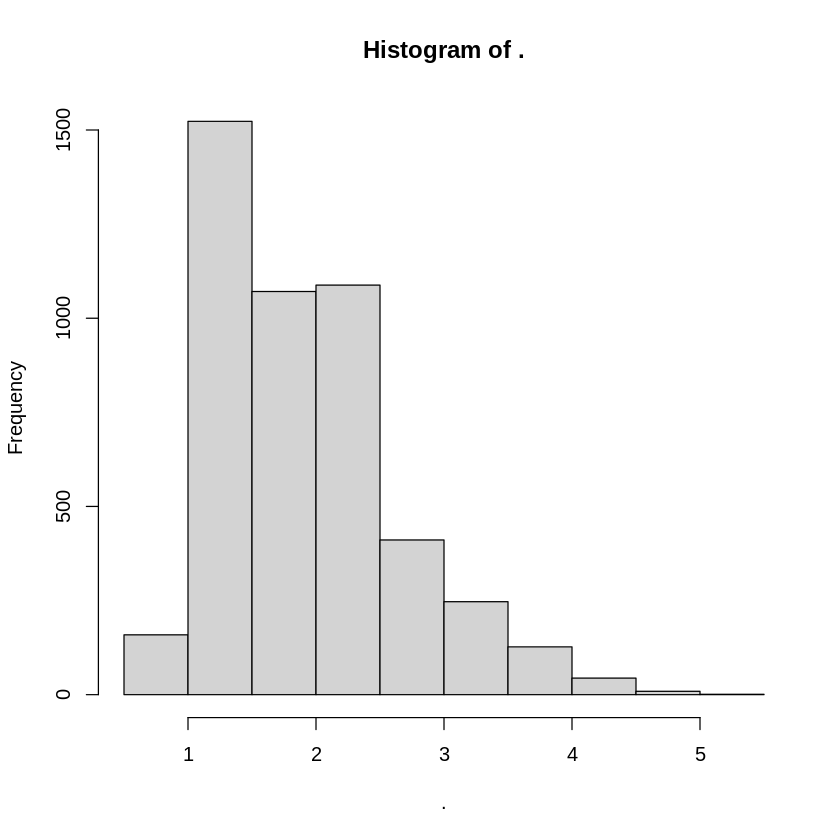

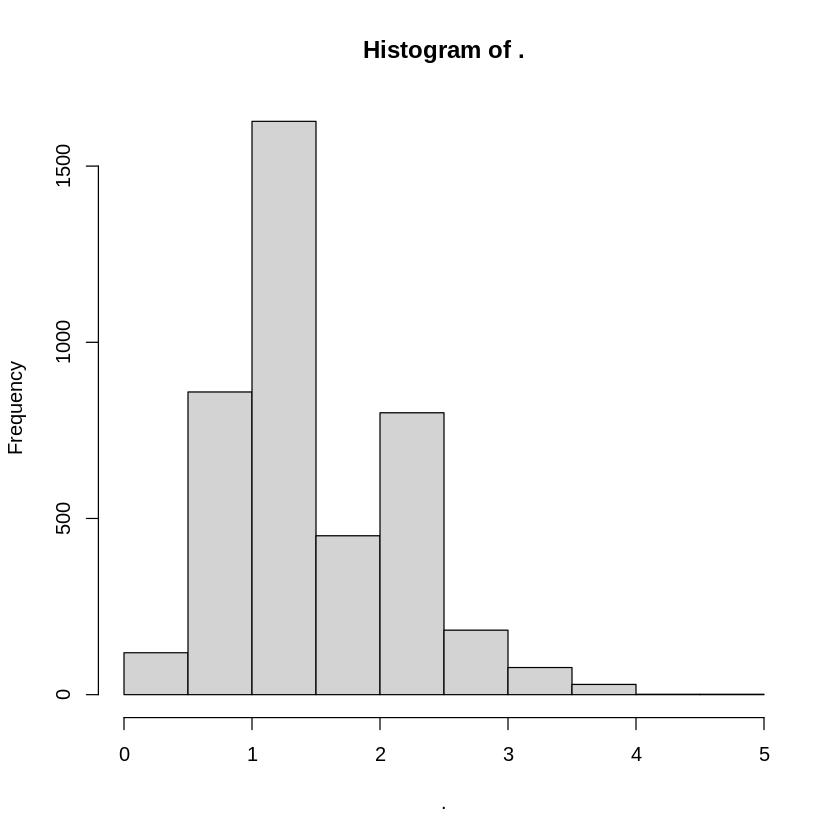

In [98]:
sss %>%
  pull(all_max_value) %>%
  log() %>%
  hist()

sss %>%
  pull(type_max_value) %>%
  log() %>%
  hist()

In [109]:
sss %>%
  select(TotalReads, type_max_value) %>%
  head()

sss %>%
  pull(TotalReads) %>%
  sum()


sss %>%
  pull(type_max_value) %>%
  sum()


TotalReads,type_max_value
<int>,<dbl>
4,0
4,4
13,6
6,4
17,8
14,4


[1] 65933

[1] 24606

In [111]:
q <- 8
m <- 24606
n <- 65933 - 24606
k <- 17


phyper(q, m, n, k, lower.tail = FALSE)

[1] 0.1402872

In [104]:
?phyper

Hypergeometric {stats},R Documentation
"x, q",vector of quantiles representing the number of white balls drawn without replacement from an urn which contains both black and white balls.
m,the number of white balls in the urn.
n,the number of black balls in the urn.
k,"the number of balls drawn from the urn, hence must be in 0,1,…, m+n."
p,"probability, it must be between 0 and 1."
nn,"number of observations. If length(nn) > 1, the length is taken to be the number required."
"log, log.p","logical; if TRUE, probabilities p are given as log(p)."
lower.tail,"logical; if TRUE (default), probabilities are P[X ≤ x], otherwise, P[X > x]."
